<a href="https://colab.research.google.com/github/sudhir5595/Denoising_Algorithm/blob/master/denoising_algorithm_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

folder="/content/gdrive/My Drive/Colab Notebooks/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
#    Activation, BatchNormalization, ReLU, Concatenate
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.datasets import cifar100, cifar10

In [ ]:
(train_data_clean, _), (test_data_clean, _) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
train_data_clean = train_data_clean.astype('float32') / 255
test_data_clean = test_data_clean.astype('float32') / 255

In [ ]:
def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data

In [ ]:
train_data_noisy = add_noise_and_clip_data(train_data_clean)
test_data_noisy = add_noise_and_clip_data(test_data_clean)

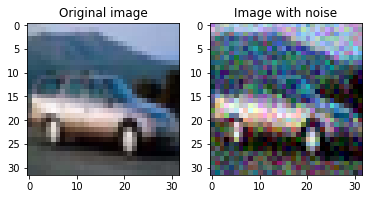

In [ ]:
idx = 4
plt.subplot(1,2,1)
plt.imshow(train_data_clean[idx])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_data_noisy[idx])
plt.title('Image with noise')
plt.show()

Now define the AutoEncoder Architecture

In [ ]:
def conv_block(x, filters, kernel_size, strides=2):
   x = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(x)
   x = tf.keras.layers.BatchNormalization()(x)
   x = tf.keras.layers.ReLU()(x)
   return x

In [ ]:
def deconv_block(x, filters, kernel_size):
   x = tf.keras.layers.Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=2,padding='same')(x)
   x = tf.keras.layers.BatchNormalization()(x)
   x = tf.keras.layers.ReLU()(x)
   return x

In [ ]:
def denoising_autoencoder():
   dae_inputs = tf.keras.layers.Input(shape=(32, 32, 3), name='dae_input')
   conv_block1 = conv_block(dae_inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 256, 3)
   conv_block5 = conv_block(conv_block4, 256, 3, 1)
   deconv_block1 = deconv_block(conv_block5, 256, 3)
   merge1 = tf.keras.layers.Concatenate()([deconv_block1, conv_block3])
   deconv_block2 = deconv_block(merge1, 128, 3)
   merge2 = tf.keras.layers.Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = deconv_block(merge2, 64, 3)
   merge3 = tf.keras.layers.Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = deconv_block(merge3, 32, 3)
   final_deconv = tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=3, padding='same')(deconv_block4)
   dae_outputs = tf.keras.layers.Activation('sigmoid', name='dae_output')(final_deconv)
  
   return tf.keras.models.Model(dae_inputs, dae_outputs, name='dae')

Training of the model

In [31]:
dae = denoising_autoencoder()
dae.compile(loss='mse', optimizer='adam')
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
dae.fit(train_data_noisy,train_data_clean,validation_data=(test_data_noisy, test_data_clean),epochs=40,batch_size=128,callbacks=[checkpoint])

Epoch 1/40
391/391 [==============================] - ETA: 0s - loss: 0.0047
Epoch 00001: val_loss improved from inf to 0.00556, saving model to best_model.h5
391/391 [==============================] - 477s 1s/step - loss: 0.0047 - val_loss: 0.0056
Epoch 2/40
391/391 [==============================] - ETA: 0s - loss: 0.0025
Epoch 00002: val_loss improved from 0.00556 to 0.00217, saving model to best_model.h5
391/391 [==============================] - 471s 1s/step - loss: 0.0025 - val_loss: 0.0022
Epoch 3/40
391/391 [==============================] - ETA: 0s - loss: 0.0022
Epoch 00003: val_loss did not improve from 0.00217
391/391 [==============================] - 473s 1s/step - loss: 0.0022 - val_loss: 0.0026
Epoch 4/40
391/391 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00004: val_loss did not improve from 0.00217
391/391 [==============================] - 473s 1s/step - loss: 0.0021 - val_loss: 0.0025
Epoch 5/40
391/391 [==============================] - ETA: 0s 

Result

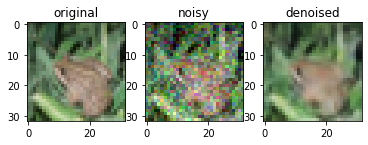

In [32]:
dae.load_weights('best_model.h5')
test_data_denoised = dae.predict(test_data_noisy)
idx = 4
plt.subplot(1,3,1)
plt.imshow(test_data_clean[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_data_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.show()

In [34]:
def mse(data_1, data_2):
   return np.square(np.subtract(data_1, data_2)).mean()
noisy_clean_mse = mse(test_data_clean, test_data_noisy)
denoised_clean_mse = mse(test_data_denoised, test_data_clean)

noisy_clean_mse, denoised_clean_mse

(0.009304722923965933, 0.0015200599)